SAS & HSE, Applied Time Series Forecasitng , Fall 2021 

<font color="blue"> Lesson #4: ARIMA model and Stationary TS </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:** 
    - stationary TS, ARMA, ARIMA, equvalence ARIMA and ES models


**Your feedback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

In [ ]:
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools


from utils import qualityMACAPE, get_autoregrmatrix

%matplotlib inline

In [ ]:
def get_autoregrmatrix(x,h,K):
    T = len(x)
    X = sc.linalg.hankel(x[:T-h-K+1], 
                          np.hstack((x[T-h-K:T-h]))) # is needed to repeat x[-K] in second part
    y = x[K+h-1:]
    return X,y

# Stationarity of TS

## Why simple linear regression is not proper alg for ts with trend and seasonality? 

Train score: 0.964, Test score: 0.675


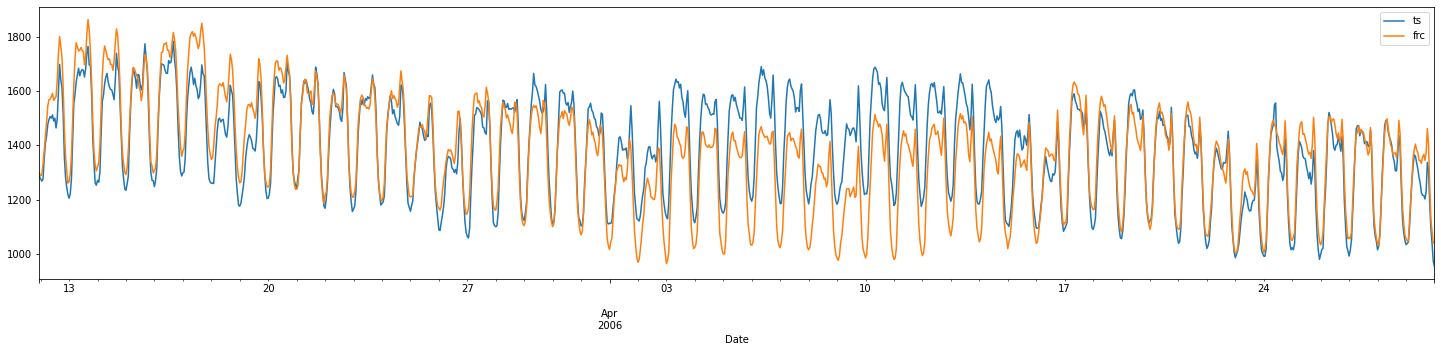

In [ ]:
# Reminder from lesson 1
ech_df = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/energy_consumption_hours.csv', sep=',', parse_dates=['Date'], dayfirst=False, index_col='Date') 
ech_df.tail(10)

K=9*168
h = 168 # delay

x_train = ech_df['EnergyCons']['2005-01-01 00:00:00':'2006-01-01 00:00:00']
x_test =  ech_df['EnergyCons']['2006-01-01 00:00:00':'2006-04-30 00:00:00']

X_train, y_train = get_autoregrmatrix(x_train,h,K)
X_test, y_test = get_autoregrmatrix(x_test,h,K)

linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)
print('Train score: %.3f, Test score: %.3f'% (linear_regression.score(X_train, y_train), linear_regression.score(X_test, y_test)))
pd.DataFrame({'ts':y_test, 'frc': linear_regression.predict(X_test)}).plot(figsize = (25,5))

Max and min values in w -542807884148251455 -551151540646809390


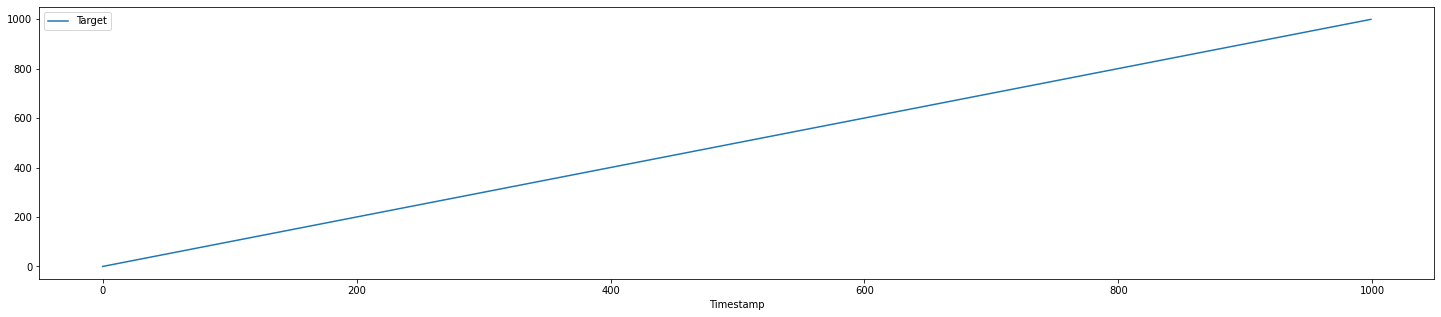

In [ ]:
# Trend time series
trend_df = pd.DataFrame([[x, x] for x in range(1000)], columns = ['Timestamp', 'Target']).set_index('Timestamp')
trend_df.plot(figsize = (25,5))
# [[x, x] for x in range(1000)]

K=10
h = 10 # delay

train = trend_df['Target'][:900]
test =  trend_df['Target'][900:]

X_train, y_train = get_autoregrmatrix(train,h,K)
X_test, y_test = get_autoregrmatrix(test,h,K)

def lin_reg_coef(x_train, y_train):
  w = np.dot( np.invert(np.dot(x_train.transpose(),x_train)), np.dot(x_train.transpose(),y_train,))
  return w

_w = lin_reg_coef(x_train=X_train, y_train=y_train)
print('Max and min values in w', max(_w), min(_w))

# linear_regression = LinearRegression()
# linear_regression.fit(X_train,y_train)
# print('Train score: %.3f, Test score: %.3f'% (linear_regression.score(X_train, y_train), linear_regression.score(X_test, y_test)))
# pd.DataFrame({'ts':y_test, 'frc': linear_regression.predict(X_test)}).plot(figsize = (25,5))

In [ ]:
# What is wrong with the train matrix?
print('Train matrix:')
print(X_train[:10])

Train matrix:
[[ 0  1  2  3  4  5  6  7  8  9]
 [ 1  2  3  4  5  6  7  8  9 10]
 [ 2  3  4  5  6  7  8  9 10 11]
 [ 3  4  5  6  7  8  9 10 11 12]
 [ 4  5  6  7  8  9 10 11 12 13]
 [ 5  6  7  8  9 10 11 12 13 14]
 [ 6  7  8  9 10 11 12 13 14 15]
 [ 7  8  9 10 11 12 13 14 15 16]
 [ 8  9 10 11 12 13 14 15 16 17]
 [ 9 10 11 12 13 14 15 16 17 18]]


In [ ]:
(5*math.pi)

15.707963267948966

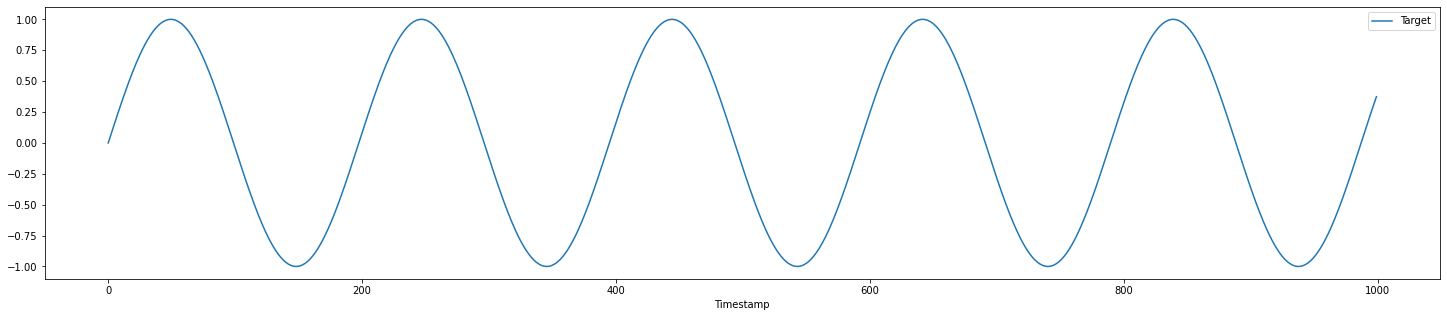

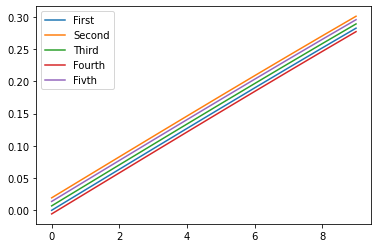

In [ ]:
# seasonal ts
# Trend time series
season_df = pd.DataFrame([[x, np.sin(x/(10*math.pi))] for x in range(1000)], columns = ['Timestamp', 'Target']).set_index('Timestamp')
season_df.plot(figsize = (25,5))

K=10
h = 10 # delay

train = season_df['Target'][:900]
test =  season_df['Target'][900:]

X_train, y_train = get_autoregrmatrix(train,h,K)
X_test, y_test = get_autoregrmatrix(test,h,K)

def lin_reg_coef(x_train, y_train):
  # print(np.dot(x_train.transpose(),x_train))
  w = np.dot( np.invert(np.dot(x_train.transpose(),x_train)), np.dot(x_train.transpose(),y_train,))
  return w

# _w = lin_reg_coef(x_train=X_train, y_train=y_train)
# print rows in train matrix
pd.DataFrame(np.array([X_train[:1][0]  , X_train[198:199][0], X_train[395:396][0], X_train[592:593][0], X_train[790:791][0]]).transpose(), columns = ['First', 'Second', 'Third', 'Fourth', 'Fivth']).plot()

**Questions**
 * What issues are expected with such a train matrix?
 * How to exclude seasonal pattern from ts?
 * How to exclude trend pattern from ts?


## Excluding of trend and seasonality patterns
 $$y_1,\dots,y_T \;\longrightarrow\;y'_2,\dots,y'_{T}, $$
 $$y'_t = y_t - y_{t-1}.$$
		





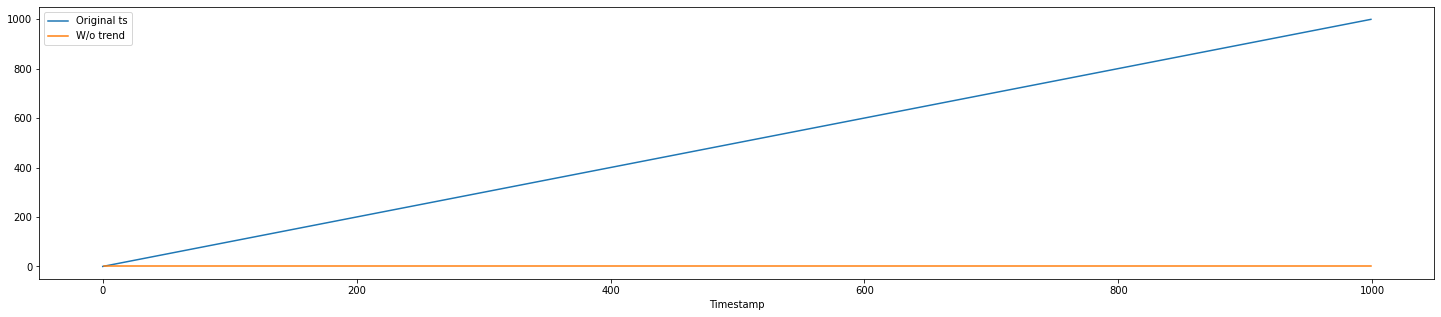

In [ ]:
# exclusion of trend component
pd.DataFrame({'Original ts':trend_df['Target'], 'W/o trend': (trend_df['Target'] - trend_df.shift(1)['Target'])}).plot(figsize = (25,5))

Seasonal differencing:
		
$$y_1,\dots,y_T \;\longrightarrow \;y'_{s+1},\dots,y'_{T}, $$
 		$$y'_t = y_t - y_{t-s}.$$	    
where $s$ is a period of seasonality

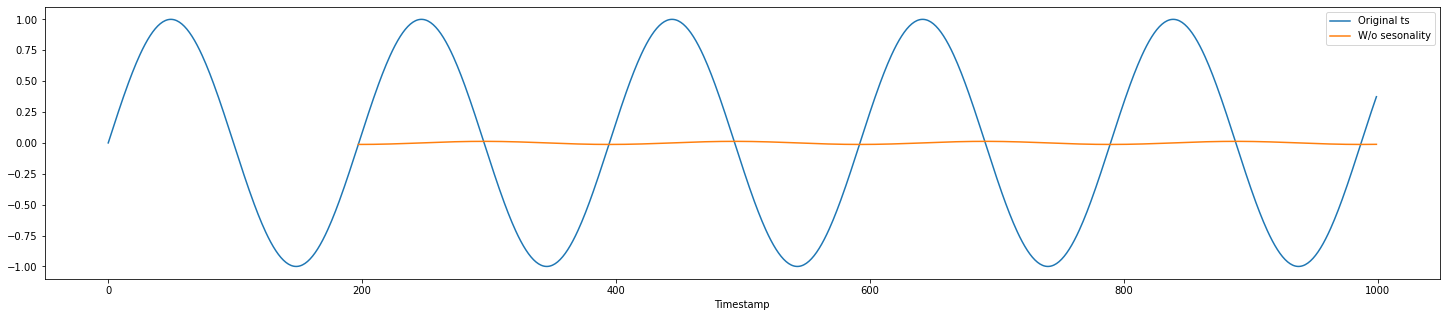

In [ ]:
# explanation of the back (shift)) operator
pd.DataFrame({'Original ts':season_df['Target'], 'W/o sesonality': (season_df['Target'] - season_df.shift(197)['Target'])}).plot(figsize = (25,5))

## Back Operator

Let's introduce the Back (shift) operator for the transformation:
$${\bf B} y_t = y_{t-1}$$

In [ ]:
# how it works
season_df.shift(1).head()

,Target
Timestamp,
0,NaN
1,0.000000
2,0.031826
3,0.063619
4,0.095348


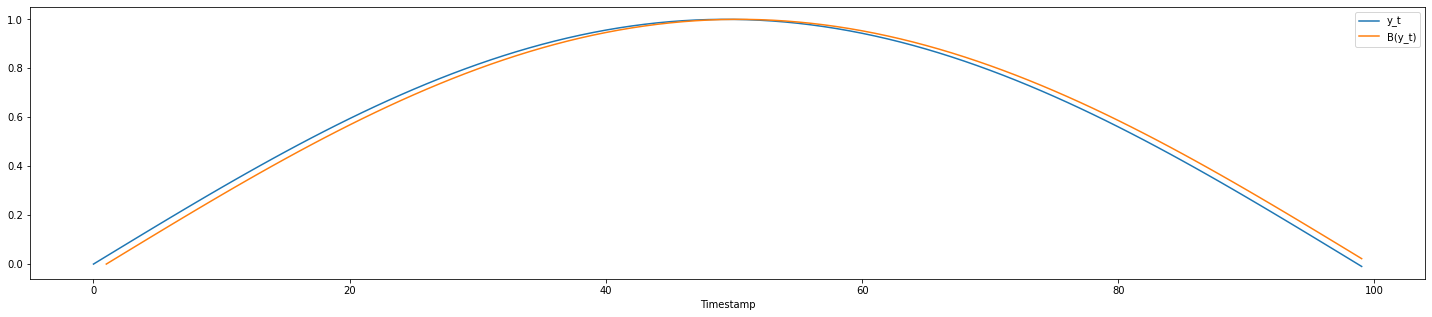

In [ ]:
# explanation of the back (shift)) operator
pd.DataFrame({'y_t':season_df['Target'], 'B(y_t)': season_df.shift(1)['Target']})[:100].plot(figsize = (25,5))

Trend differencing:
$$y_1,\dots,y_T \;\longrightarrow \;y'_{s+1},\dots,y'_{T}, $$
 		$$y'_t = y_t - y_{t-1} = ({\bf 1}-\color{red}{\bf B})y_t,$$

assuming that ${\bf 1}$ is identity operator: ${\bf 1} y_t = y_t$	    
Seasonal differencing:
		
$$y_1,\dots,y_T \;\longrightarrow \;y'_{s+1},\dots,y'_{T}, $$
 		$$y'_t = y_t - y_{t-s} = ({\bf 1}-\color{red}{{\bf{B^s}}})y_t.$$	    
where $s$ is a period of seasonality

## Stationarity Definition

Time series $y_1,\dots,y_T, \dots$ is $\color{red}{stationary}$  if $\forall \tau$ distribution $y_t,\dots,y_{t+\tau}$ does not depend on $t$, i.e. its properties do not depend on time.

 * Time series with trend or seasonality are not stationary.


 * Time series with a-periodical cycles are stationary since it is impossible to predict where the maximums and minimums will be located.

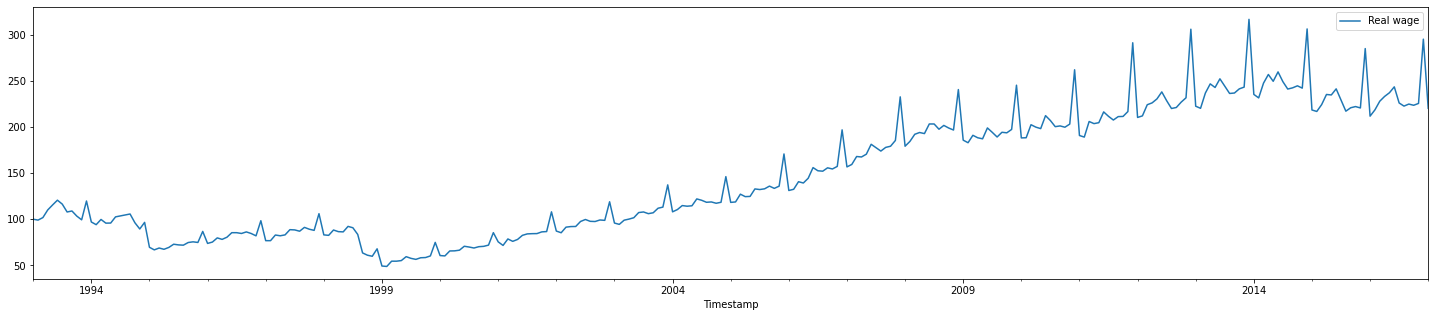

In [ ]:
# lets make wage ts stationary
ts_wage = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/33b78c9be63831567f8036ad40c5859e824d30f7/data/monthly-wage.csv', sep=';', decimal='.', parse_dates=True, index_col='Month')
ts_wage.index.names=['Timestamp']
# ts = pd.read_csv('./data/TimeSeries_Data10.csv', sep=',', decimal='.')
ts_wage = ts_wage.sort_index() # sort index
ts_wage.plot(figsize = (25,5))

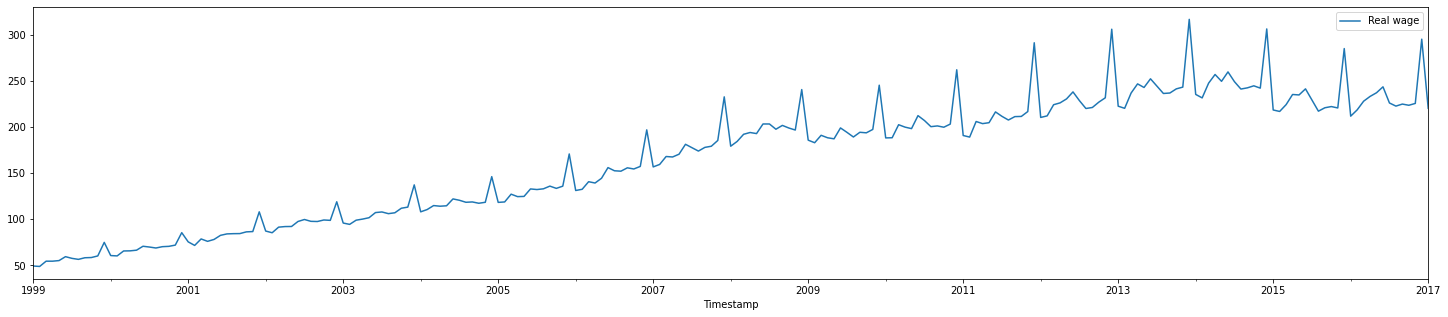

In [ ]:
# cut first steps
ts_wage = ts_wage.loc['01.01.1999':'01.01.2017']
ts_wage.plot(figsize=(25,5))

 * Make it Stationary in term of variance of its values

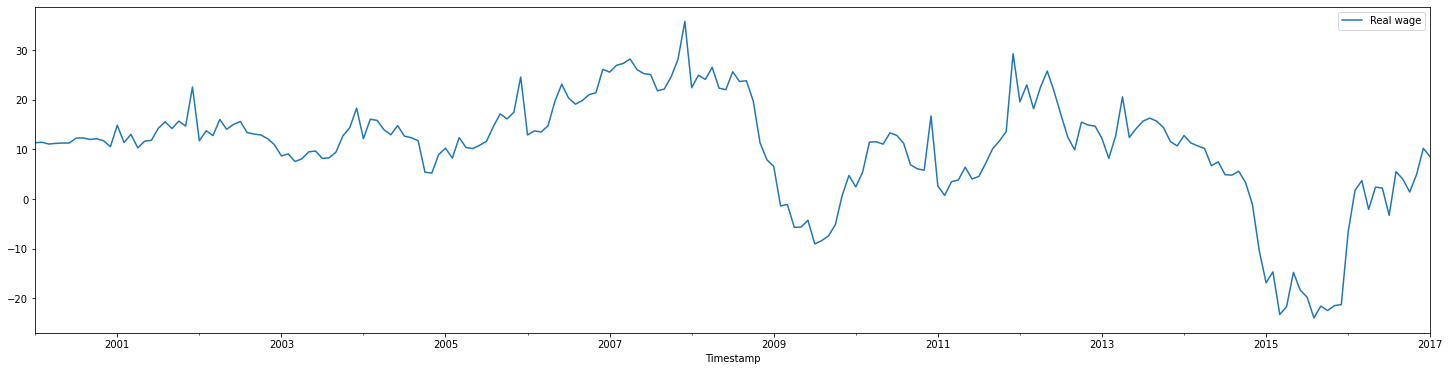

In [ ]:
# Lets transform wage ts
# seasonal differencing
s = 12
sdiff_ts_wage = (ts_wage - ts_wage.shift(s))[s:]
sdiff_ts_wage.plot(figsize=(25,6))

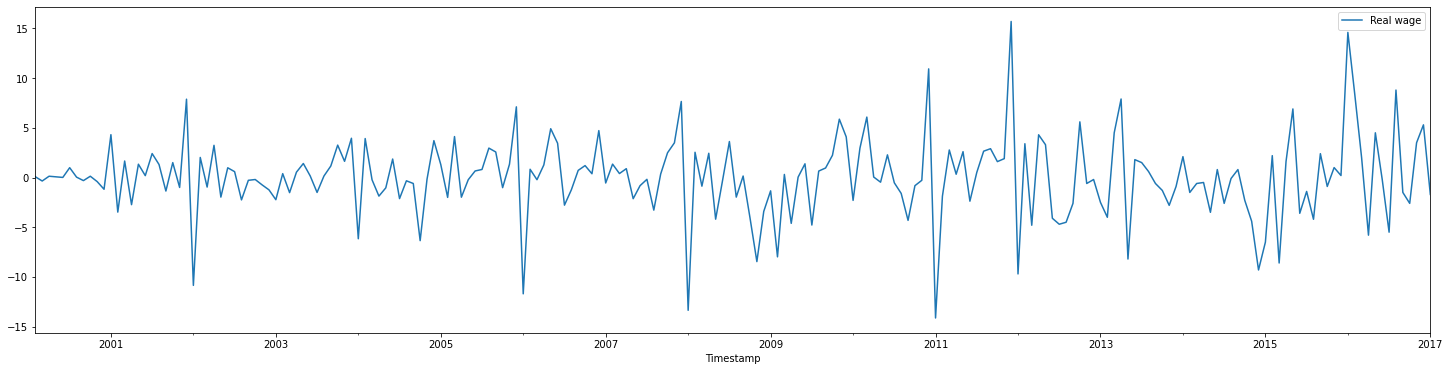

In [ ]:
# excluding trend component
diff_sdiff_ts_wage = (sdiff_ts_wage  - sdiff_ts_wage.shift(1))[1:]
diff_sdiff_ts_wage.plot(figsize=(25,6))

**Questions:**
   * Is that TS stationary?
   * How to check it?
    - KPSS-test: https://en.wikipedia.org/wiki/KPSS_test
    - Dickey-Fuller test: https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test

In [ ]:
# Augmented Dickey-Fuller unit root test: 
# H0: ts is stationary
df_stat = stattools.adfuller(np.array(diff_sdiff_ts_wage['Real wage']))
print('The Augmented Dickey-Fuller test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ncritical values: %s' % 
      (df_stat[0], df_stat[1], df_stat[2], df_stat[4]))

The Augmented Dickey-Fuller test statistic -16.559783, 
pvalue: 0.00 
maximal Lag: 0 
critical values: {'1%': -3.462980134086401, '5%': -2.875885461947131, '10%': -2.5744164898444515}


In [ ]:
# Kwiatkowski–Phillips–Schmidt–Shin
# H0: ts is stationary
kpss_stat= stattools.kpss(np.array(diff_sdiff_ts_wage['Real wage']))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.044294, 
pvalue: 0.10 
maximal Lag: 15 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



## Box-Cox transformation
Lets stabilize monotoniously changin dispersion
$$
y'_t=\begin{cases}
  \ln y_t, & \lambda=0, \\
  \left(y_t^\lambda-1\right)/\lambda, & \lambda\neq 0.
  \end{cases}
$$


<img src="https://harlecin.netlify.com/post/box-cox-and-other-transformations_files/figure-html/unnamed-chunk-1-1.png" alt="Drawing" style="width: 100px;"/>


In [ ]:
ts_wage['Real wage']

Timestamp
1999-01-01     49.22
1999-02-01     48.77
1999-03-01     54.48
1999-04-01     54.48
1999-05-01     55.13
               ...  
2016-09-01    224.90
2016-10-01    223.60
2016-11-01    225.60
2016-12-01    295.30
2017-01-01    220.30
Name: Real wage, Length: 217, dtype: float64

In [ ]:
from copy import deepcopy
ts_wage_boxcox = deepcopy(ts_wage)
# find optimal lambda 
print('optimal lambda:', stats.boxcox(ts_wage['Real wage'])[1])

optimal lambda: 0.9227089747975844


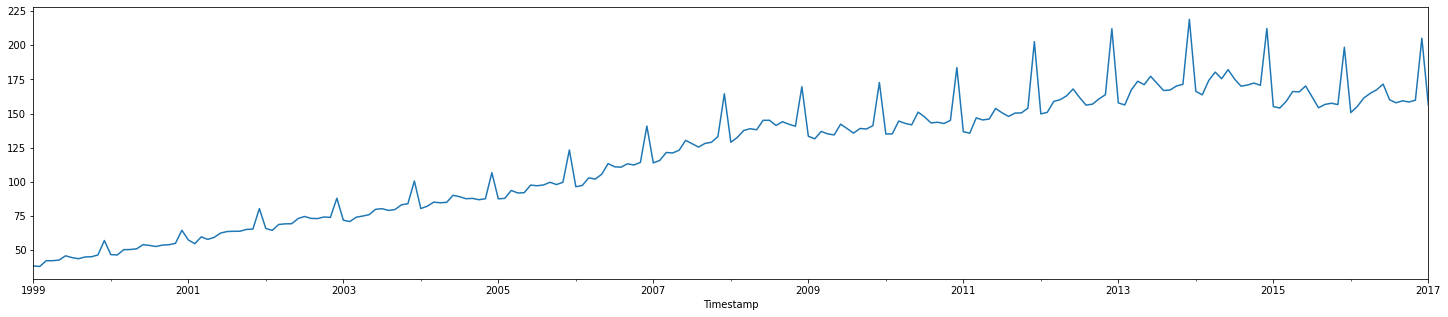

In [ ]:
ts_wage_boxcox['wage_boxcox'] = stats.boxcox(ts_wage['Real wage'])[0]
ts_wage_boxcox['wage_boxcox'].plot(figsize=(25,5))

**Question**
  * Does it look like with stable dispersion?

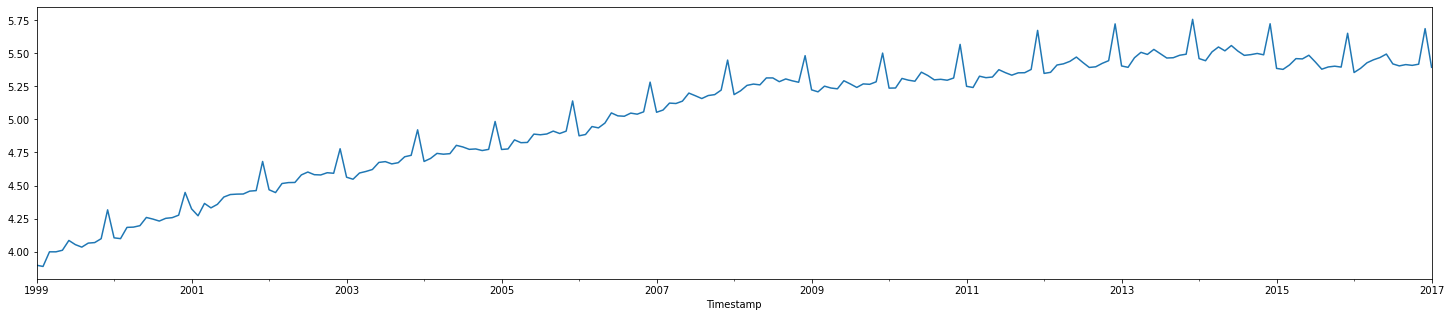

In [ ]:
ts_wage_boxcox['wage_boxcox'] = np.log(ts_wage)
ts_wage_boxcox['wage_boxcox'].plot(figsize=(25,5))
# a= stats.boxcox(np.array(ts_wage['Real wage']), lmbda=0.1, alpha=0.05)[0]

** Questions: **
   * Which $\lambda$ is more proper for this TS (0 or 0.92)?
   * Is transformed TS stationary?

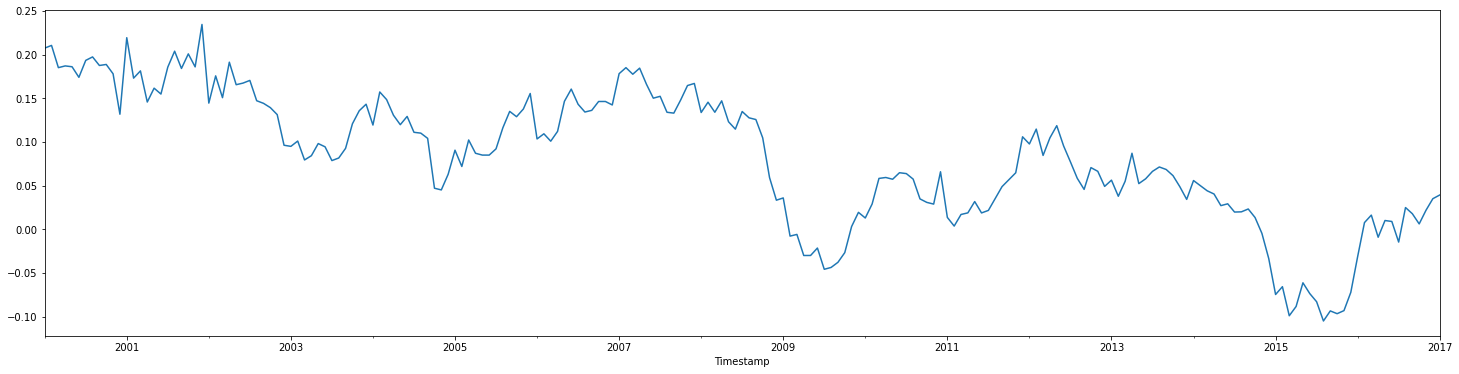

In [ ]:
# Lets transform wage ts
# seasonal differencing
s = 12
sdiff_ts_wage_boxcox = (ts_wage_boxcox - ts_wage_boxcox.shift(s))[s:]
sdiff_ts_wage_boxcox['wage_boxcox'].plot(figsize=(25,6))

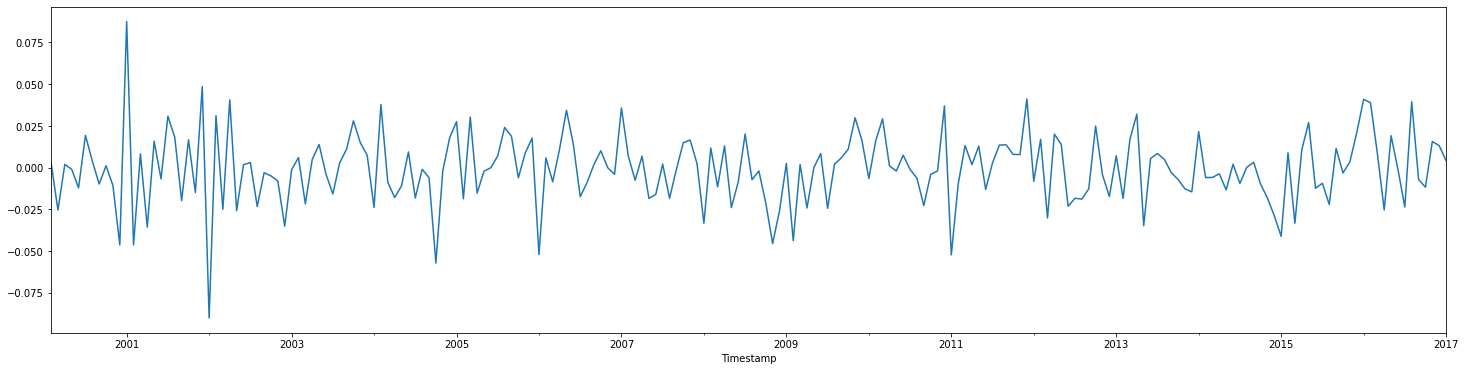

In [ ]:
diff_sdiff_ts_wage_boxcox = (sdiff_ts_wage_boxcox  - sdiff_ts_wage_boxcox .shift(1))[1:]
diff_sdiff_ts_wage_boxcox['wage_boxcox'].plot(figsize=(25,6))

In [ ]:
# Augmented Dickey-Fuller unit root test
# H0: ts is stationary
df_stat = stattools.adfuller(np.array(diff_sdiff_ts_wage_boxcox['wage_boxcox']))
print('The Augmented Dickey-Fuller test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ncritical values: %s' % 
      (df_stat[0], df_stat[1], df_stat[2], df_stat[4]))

The Augmented Dickey-Fuller test statistic -5.227607, 
pvalue: 0.00 
maximal Lag: 11 
critical values: {'1%': -3.4648754262570978, '5%': -2.876714157488788, '10%': -2.574858699001736}


In [ ]:
# Kwiatkowski–Phillips–Schmidt–Shin
# H0: ts is stationary
kpss_stat= stattools.kpss(np.array(diff_sdiff_ts_wage_boxcox['wage_boxcox']))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.062453, 
pvalue: 0.10 
maximal Lag: 15 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



# ARIMA models



## ARIMA for stationarity time series
$$y_t = \underbrace{c+\sum_{i=1}^{p} \alpha_iy_{t-i}}\limits_{AR}+\underbrace{\sum_{j=1}^{q} \beta_j\varepsilon_{t-j}}\limits_{MA}+\varepsilon_t$$

or in canonical form (using back-operator ${\bf B}$):

$$\phi\left({\bf B}\right)(y_t-\mu) = \theta\left({\bf B}\right)\varepsilon_t.$$

$\varepsilon_t$- random variable from $N(0, \sigma^2)$, $E\varepsilon_t=0, ~E\varepsilon_i\varepsilon_j=0$


<!-- 
$$ARMA(p,q)\colon \;\; y_t = \phi_1 y_{t-1} + \dots + \phi_p y_{t-p} + \varepsilon_t + \theta_1\varepsilon_{t-1} + \theta_2\varepsilon_{t-2} + \dots + \theta_q \varepsilon_{t-q},$$ -->
 <!-- where $y_t~-$ is a stationary time series with zero average, $\phi_1,\dots,\phi_p,\theta_1,\dots,\theta_q~-$ are constants ($\phi_p \neq 0$, $\theta_q\neq0$), $\varepsilon_t~-$ is gaussian white noise with zero average and constant dispersion $\sigma_\varepsilon^2.$

    \bigskip

    If the average equals $\mu$ the model looks like
    $$y_t = \alpha + \phi_1y_{t-1} + \phi_2 y_{t-2} + \dots + \phi_p y_{t-p} + \varepsilon_t + \theta_1\varepsilon_{t-1} + \theta_2\varepsilon_{t-2} + \dots + \theta_q \varepsilon_{t-q},$$
    where $\alpha=\mu\left(1-\phi_1-\dots-\phi_p\right).$

    \bigskip

    Another way to note:
    $$\phi\left(B\right)(y_t-\mu) = \theta\left(B\right)\varepsilon_t.$$ -->

**Question:**
   * What is $\phi\left({\bf B}\right)$ and $\theta\left({\bf B}\right)$?
    
    

**Questions:**
  * Write down equation in canonical form for next TS:
       - 1) $y_t ={0.5\cdot y_{t-1}} + 1 +\varepsilon_t$

          Answer

          $ y_t - 0.5\cdot y_{t-1} - 1 = \varepsilon_t$

          Note: ${\bf{B}}(c) = c$

          $({\bf{1} - 0.5\cdot B} ) (y_t-2) =  \varepsilon_t$

          $\Rightarrow$

          $\phi({\bf{B}}) = ({\bf{1 - 0.5 \cdot B}})$

          $\theta(\bf{B}) = \bf{1} $

       - 2) $y_t =y_{t - p} +\varepsilon_t$, where $p>1$ - period of seasonality

          Answer

          $y_t - y_{t-p} = \varepsilon_t$

          ${\bf(1 - B^p)}y_t = \varepsilon_t $

          $\Rightarrow$

          $\phi(\bf{B}) = \bf{(1 - B^p)}$

          $\theta(\bf{B}) = \bf{1}$
   
<!-- * Show that $\phi(B)$ in equations above has unit roots.
   
   <Answer>
   
* Explain why linear operator $1-B$ is not invertable 
       Hint:
       - 1) show that back operator $B$ is a linear operator with norm 1;
       - 2) use the fact that if $||A||=1\Rightarrow $(1-A)$ is not invertable
* Why ARMA model works only with stationary TS?  -->

## ARIMA model for non-stationary time series
In order to make ts stationary we apply trend ${\bf(1-\bf B)}$ differencing $d$ times and seasonal ${\bf(1-B^s)}$ differencing $D$ times.

Final ts model:

$$\color{red}{\bf(1-B)^d(1-B^s)^D}y_t = \underbrace{c+\sum_{i=1}^{p} \alpha_iy_{t-i}}\limits_{AR}+\underbrace{\sum_{j=1}^{q} \beta_j\varepsilon_{t-j}}\limits_{MA}+\varepsilon_t$$

or in canonical form:

$$\phi\left({\bf B}\right)\color{red}{\bf(1-B)^d(1-B^s)^D}(y_t-\mu) = \theta\left(\bf B\right)\varepsilon_t.$$

$\varepsilon_t$- random variable from $N(0, \sigma^2)$, $E\varepsilon_t=0, ~E\varepsilon_i\varepsilon_j=0$


## Parameters of ARIMA model

$${\bf(1-B)^{\color{red}{d}}(1-B^s)^{\color{red}D}}y_t = \underbrace{c+\sum_{i=1}^{\color{red}p} \alpha_iy_{t-i}}\limits_{AR}+\underbrace{\sum_{j=1}^{\color{red}q} \beta_j\varepsilon_{t-j}}\limits_{MA}+\varepsilon_t$$

Classic form of ARIMA model implies that there are some seasonal Autoregression and Moving Average Components


$${\bf(1-B)^{\color{red}{d}}(1-B^s)^{\color{red}D}}y_t = \underbrace{c+\sum_{i=1}^{\color{red}p} \alpha_iy_{t-i}}\limits_{AR}+\underbrace{\sum_{j=1}^{\color{red}q} \beta_j\varepsilon_{t-j}}\limits_{MA}+\underbrace{\sum_{l=1}^{\color{red}P} \delta_ly_{t-\color{red}{s\cdot l}}}\limits_{seasonal~AR}+\underbrace{\sum_{m=1}^{\color{red}Q} \beta_j\varepsilon_{t-\color{red}{s*m}}}\limits_{seasonal~MA}+\varepsilon_t$$


Classic ARIMA model is discribed with 6 parameters:
$$ARIMA(p, d, q)\times(P, D, Q)_s$$
where

 - $p~-$ is a number of non-seasonal AR components
 - $q~-$ is a number of non-seasonal MA components
 - $d~-$ is a number of trend-differencing applied to make ts stationary
 - $P~-$ is a number of seasonal AR components
 - $Q~-$ is a number of seasonal MA components
 - $D~-$ is a number of seasonal-differencing to make ts stationary




# Additive ES models are subset of ARIMA models


ARIMA contains all ES models with additive trend and additive seasonality

   * ARIMA(p=0,d=1,q=1) is equivalent to Simple ES with
$${\bf(1-B)}y_t = {\bf(1-\phi_1 B)}\varepsilon_t$$
$$\phi_1 = 1-\alpha$$

Proof:
$$y_t-y_{t-1} = \varepsilon_t-\phi_1 \varepsilon_{t-1}=y_t-\hat{y}_t - (1-\alpha)\cdot (y_{t-1}-\hat{y}_{t-1}) $$
    
$$\hat{y}_t= y_{t-1} - y_{t-1}+\alpha y_{t-1} + (1-\alpha)\cdot\hat{y}_{t-1}=\alpha y_{t-1}+ \hat y_{t-1} - \alpha \hat y_{t-1}={\hat{y}_{t-1}+\alpha\cdot e_{t-1}}$$

   * ARIMA(p=0,d=2, q=2) is equivalent to Holt (linear trend) with:
$${\bf(1-B)^2}y_t = {\bf(1-\phi_1 B-\phi_2 B^2)}\varepsilon_t$$
$$\phi_1 = 2-\alpha-\alpha\beta, \text{ }\phi_2 = \alpha-1$$
	

   * Damped-trend linear exponential smoothing is the ARIMA(1,1,2) model
$${\bf(1-\phi B)(1-B)}y_t = {\bf(1-\theta_1 B-\theta_2 B^2)}\varepsilon_t$$
$$\theta_1 = 1+\phi-\alpha-\alpha\beta\phi, \text{ } \theta_2 = (\alpha-1)\phi$$
$\phi$ - coefficient of damped trend;

* 	Additive Winters (additive seasonal) exponential smoothing is the ARIMA$(0,1,s+1)(0,1,0)_s$ model
		$${\bf(1-B)(1-B^s)}y_t = {\bf(1-\theta_1 B-\theta_2 B^s-\theta_3B^{s+1})}\varepsilon_t$$
		$$\theta_1 = 1-\alpha$$
		$$\theta_2 = 1-\gamma(1-\alpha)$$
		$$\theta_3 = (1-\alpha)(\gamma-1)$$

* Theil-Wage model (additive trend and seasonality ES model) is equivalent to ARIMA$(0,1,s+1)(0,1,0)_s$  :
$${\bf(1-B)(1-B^s)}y_t = {\bf\Bigl[ 1-\sum_{j=1}^{s+1}\theta_jB^j \Bigr]}\varepsilon_t$$
$$
		\theta_j =
		\begin{cases}
		1-\alpha-\alpha\beta &\text{$j = 1$}\\
		-\alpha\beta &\text{$2\leq j\leq s-1$}\\
		1-\alpha\beta-\gamma(1-\alpha) &\text{$j=s$}\\
		(1-\alpha)(\gamma-1) &\text{$j=s+1$}
		\end{cases}
$$

# Practice: Realize Box-Cox transformation (optional)

As you've seen boxcox transformation from scipy does not work well.
It's suggested to realize method for searching optimal $\lambda$ for boxcox transformation.
Approach for finding the optimal $\lambda$ is descibed <a href="file:///C:/Users/rusrom/Downloads/Guerrero_JoF1993.pdf">here</a>.  

You need to replace all 'TODO' below by some code:

In [ ]:
import numpy as np
class boxcox():
    def __init__(self, lmbda=None, shift=0):
        '''
    Box Cox Transforms
    Transforms data are to be normal. Also known as power transform.
    
    Parameters
        ----------
    lmbda: float or None
        lmbda the power parameter. The None input automatically calculates
        lmbda based on method guerrero
    shift: float
        Use to normalize data by shifting data to all positive values
        
        '''
        self.lmbda = lmbda
        self.shift = shift
        self.y = []
        self.method = 'guerrero'
        
    def transform(self, x, n=2):
        '''
            x: time series
            n: number of subseries with constant dispersion
        '''
        x = 1.0*np.asarray(x)
        
        if self.shift>0:
            x=  'TODO: shift time series up'
            
        if self.lmbda is None:
            self.lmbda = 'TODO: shift time series up'
            
        
            
        if self.lmbda == 0:
            self.y = 'TODO: '
        else:
            self.y = 'TODO: '
        return self.y, self.lmbda
        
    def optimal_lambda(self,x, n=2):
        """
        Parameters
        ----------
        x - time series with different variance through the time
        n - number of subseries in x, each subseries x_i has constant variance sigma_i and constant mean m_i
        The method states, that optimal lambda should be chosen in such a way that
         
         sigma_i/(m_i)**(1-lambda) = constant, for all i=1,...,n
        
        you need to find solution for the follow Regression problem:
        
        log(sigma_i) = w_1 + w_2*log(m_i), where
        w_2 = 1-lambda
        
        """
        x = 1.0*np.asarray(x)
               
        sigma = 'TODO: initialize array for log(sigma_i)'
        m = 'TODO: initialize array for matrix of regression [1, log(m_i)]'

        r = len(x)/n  # the length of each subseries

        for i in range(n):
            m[1][i] = 'TODO: fill matrix of regression'
            sigma[i] = 'TODO: fill array of sigma'

        # find the solution for regression Xw=y, where X = m, w[1] = 1-lambda, 
        w = np.dot(np.linalg.inv(np.dot(X,X.T)),np.dot(X,y))[1]
        
        self.lmbda = 'TODO: set value of lambda'
        
        print self.lmbda
        
        return self.lmbda

    def inverse(self, y=None):
        """
        Parameters
        ----------
        y: time series

        Returns
        -------
        x: inverse transformed ts
    
        """
        if y is None:
            y = self.y
        
        if self.lmbda == 0:
            x = 'TODO' 
        else:
            x = 'TODO'
        return x        

In [ ]:
# Check on Wage data
# boxcox for wage dataset 
ts_wage = pd.read_csv('./data/monthly-wage.csv', sep=';', decimal='.', parse_dates=True, index_col='Month')

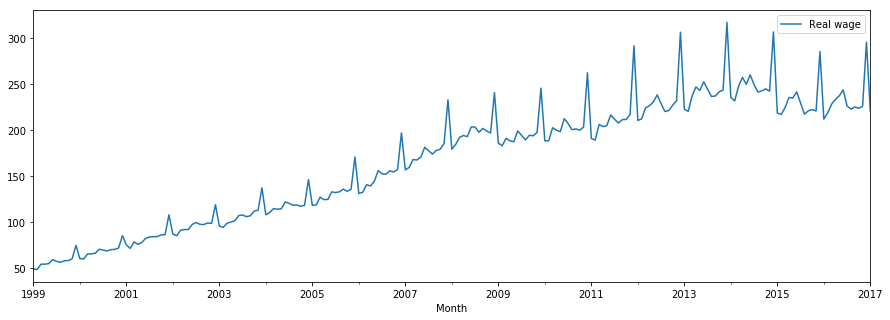

In [ ]:
# cut first steps
ts_wage = ts_wage.ix['01.01.1999':'01.01.2017']
ts_wage.plot(figsize=(15,5))

In [ ]:
bc = boxcox()
ts_wage['wage_boxcox'], lmbda = bc.transform(ts_wage['Real wage'],n=18)
print ('lambda=', lmbda)
ts_wage['wage_boxcox'].plot(figsize=(15,5))

# Materials
- Лукашин Ю.П. Адаптивные методы краткосрочного прогнозирования временных рядов. Финансы и статистика. 2003, главы 1,4,5,7.
- Магнус Я.Р., Катышев П.К., Пересецкий А.А. Эконометрика. Начальный курс., глава 11